In [1]:
# Cell 1: Setup and Imports
# ------------------------------------------------------------------------------
import pandas as pd
from transformers import pipeline
import torch

# Helper function to refine sentiment labels based on score thresholds
def refine_labels(sentiment_score):
    """
    Refines sentiment based on score thresholds.
    Args:
    - sentiment_score (float): The score output by the sentiment model.

    Returns:
    - str: Refined sentiment category as 'Positive', 'Negative', or 'Neutral'.
    """
    if sentiment_score > 0.6:
        return "Positive"
    elif sentiment_score < 0.4:
        return "Negative"
    else:
        return "Neutral"

print("Environment setup complete. Ready to load the dataset.")

/opt/anaconda3/envs/tensor_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment setup complete. Ready to load the dataset.


In [2]:
# Cell 2: Load Dataset and Handle Errors
# ------------------------------------------------------------------------------
data_file_path = "UScomments.csv"
try:
    data = pd.read_csv(data_file_path, on_bad_lines="skip")
    print(f"Successfully loaded dataset: {data_file_path}")
except (pd.errors.ParserError, FileNotFoundError) as e:
    print(f"Error loading the dataset: {e}")
    exit()

# Verify presence of necessary columns and extract comments
if 'comment_text' not in data.columns:
    print("Error: The column 'comment_text' does not exist in the dataset.")
    exit()

all_comments = data['comment_text'].astype(str).tolist()
if not all_comments:
    print("Error: No comments found in the dataset.")
    exit()

print(f"Dataset loaded successfully with {len(all_comments)} comments.")


Successfully loaded dataset: UScomments.csv
Dataset loaded successfully with 691400 comments.


/var/folders/37/4v2592095c56rcdkbdhhjvgr0000gn/T/ipykernel_15204/3973909879.py:5: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_file_path, on_bad_lines="skip")


In [3]:
# Cell 3: Sentiment Analysis using Pre-trained Model
# ------------------------------------------------------------------------------
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
device = 0 if torch.cuda.is_available() else -1

try:
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name, device=device)
    print(f"Sentiment model '{model_name}' loaded successfully on {'GPU' if device == 0 else 'CPU'}.")
except Exception as e:
    print(f"Error initializing sentiment analysis pipeline: {e}")
    exit()

# Sentiment analysis on sampled comments
sample_comments = all_comments[:1000]
batch_size = 100
results = []

# Analyze in batches to avoid memory issues
for i in range(0, len(sample_comments), batch_size):
    batch_comments = sample_comments[i:i + batch_size]
    try:
        batch_results = sentiment_analyzer(batch_comments)
        results.extend(batch_results)
    except Exception as e:
        print(f"Error processing batch {i // batch_size + 1}: {e}")

# Create a DataFrame with sentiments
df_sentiments = pd.DataFrame([
    {"Comment": comment, "Sentiment Label": result['label'], "Sentiment Score": result['score']}
    for comment, result in zip(sample_comments, results)
])
print("Sentiment Analysis Results:")
print(df_sentiments.head(10).to_string(index=False))

Sentiment model 'distilbert-base-uncased-finetuned-sst-2-english' loaded successfully on CPU.


Token indices sequence length is longer than the specified maximum sequence length for this model (2491 > 512). Running this sequence through the model will result in indexing errors


Error processing batch 2: The size of tensor a (2491) must match the size of tensor b (512) at non-singleton dimension 1
Sentiment Analysis Results:
                                                                                Comment Sentiment Label  Sentiment Score
                                                      Logan Paul it's yo big day ‼️‼️‼️        POSITIVE         0.996544
I've been following you from the start of your vine channel and have seen all 365 vlogs        POSITIVE         0.995116
                                                     Say hi to Kong and maverick for me        POSITIVE         0.999260
                                                                    MY FAN . attendance        POSITIVE         0.999641
                                                                             trending 😉        POSITIVE         0.886796
                                                                #1 on trending AYYEEEEE        POSITIVE         0.985437
    

In [4]:
# Cell 4: Sentiment Distribution Analysis
# ------------------------------------------------------------------------------
sentiment_counts = df_sentiments['Sentiment Label'].value_counts()
print("Sentiment Distribution for Sampled Comments:")
print(sentiment_counts)

avg_scores = df_sentiments.groupby('Sentiment Label')['Sentiment Score'].mean()
print("Average Sentiment Scores for Each Label:")
print(avg_scores)

Sentiment Distribution for Sampled Comments:
Sentiment Label
NEGATIVE    533
POSITIVE    367
Name: count, dtype: int64
Average Sentiment Scores for Each Label:
Sentiment Label
NEGATIVE    0.964600
POSITIVE    0.959849
Name: Sentiment Score, dtype: float64


In [5]:
# Cell 5: Extracting Extreme Sentiments
# ------------------------------------------------------------------------------
# Top 5 positive and negative comments
top_positive_comments = df_sentiments[df_sentiments['Sentiment Label'] == 'POSITIVE'].nlargest(5, 'Sentiment Score')
top_negative_comments = df_sentiments[df_sentiments['Sentiment Label'] == 'NEGATIVE'].nlargest(5, 'Sentiment Score')

print("Top 5 Positive Comments:")
print(top_positive_comments[['Comment', 'Sentiment Score']].to_string(index=False))

print("Top 5 Negative Comments:")
print(top_negative_comments[['Comment', 'Sentiment Score']].to_string(index=False))

Top 5 Positive Comments:
                                                                                                                      Comment  Sentiment Score
                                                                                                       please say : ameterasu         0.999888
as a left handed iPhone user, I´m wondering, if you can go to the Control Center by swiping from the left top corner, too? :/         0.999886
                                                           What if it's to dark to recognise youre face how do you unlock it?         0.999884
                                                                             Isn't it time for a Wonder Woman honest trailer?         0.999882
                                                                                                              5TH ON TRENDING         0.999881
Top 5 Negative Comments:
                                                                                      Commen

In [6]:
# Cell 6: Token Frequency Analysis
# ------------------------------------------------------------------------------
from collections import Counter
import re

# Tokenize and calculate word frequency
all_words = []
for comment in df_sentiments['Comment']:
    words = re.findall(r'\b\w+\b', comment.lower())
    all_words.extend(words)

# Calculate and display top 50 most common words
word_freq = Counter(all_words)
print("Top 50 Most Common Words in the Dataset:")
print("\n".join([f"{word}: {freq}" for word, freq in word_freq.most_common(50)]))

Top 50 Most Common Words in the Dataset:
nigger: 1244
the: 538
i: 315
to: 288
a: 276
it: 270
you: 264
and: 246
is: 222
of: 173
this: 168
s: 160
that: 139
t: 131
for: 127
n: 97
on: 94
in: 92
can: 91
be: 89
are: 89
iphone: 89
with: 87
have: 85
but: 84
so: 84
he: 84
like: 79
people: 78
not: 74
my: 73
was: 72
if: 66
just: 65
do: 64
they: 64
your: 63
what: 60
say: 59
word: 57
all: 53
me: 53
how: 52
get: 49
apple: 49
from: 44
about: 44
m: 43
more: 42
see: 42


In [7]:
# Cell 7: Identify and Flag Highly Offensive Comments
# ------------------------------------------------------------------------------
# Create a custom list of highly offensive words to monitor
highly_offensive_words = ["nigger", "faggot", "bitch", "cunt"]

def contains_offensive_word(comment, offensive_list):
    """
    Checks if a comment contains any offensive words from a given list.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of words to check against.

    Returns:
    - bool: True if any word in the list is found in the comment, False otherwise.
    """
    return any(word in comment.lower() for word in offensive_list)

# Flag highly offensive comments
df_sentiments['Offensive_Flag'] = df_sentiments['Comment'].apply(lambda x: contains_offensive_word(x, highly_offensive_words))

# Display flagged comments and count
flagged_count = df_sentiments['Offensive_Flag'].sum()
print(f"\nNumber of Highly Offensive Comments Identified: {flagged_count}")

# Show a few flagged comments if any are found
flagged_comments = df_sentiments[df_sentiments['Offensive_Flag']]
if not flagged_comments.empty:
    print("Sample Highly Offensive Comments:")
    print(flagged_comments[['Comment', 'Sentiment Label', 'Sentiment Score']].head(5).to_string(index=False))



Number of Highly Offensive Comments Identified: 8
Sample Highly Offensive Comments:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Comment Sentiment Label  Sentiment Score
As a Black American, I don't think it's that big of a deal. I haven't even seen the clip but from what I've heard and from wh

In [8]:
# Cell 8: Update Sentiment Labels and Adjust Scores for Offensive Comments
# ------------------------------------------------------------------------------
# Update sentiment labels and scores for highly offensive comments
df_sentiments.loc[df_sentiments['Offensive_Flag'], 'Sentiment Label'] = 'Highly Offensive'
df_sentiments.loc[df_sentiments['Offensive_Flag'], 'Sentiment Score'] = 1.0  # Set the maximum intensity

# Display updated sentiment distribution
updated_distribution = df_sentiments['Sentiment Label'].value_counts()
print("Updated Sentiment Distribution (Including Highly Offensive Comments):")
print(updated_distribution)


Updated Sentiment Distribution (Including Highly Offensive Comments):
Sentiment Label
NEGATIVE            526
POSITIVE            366
Highly Offensive      8
Name: count, dtype: int64


In [9]:
# Cell 9: Text-Based Summary Report
# ------------------------------------------------------------------------------
def generate_summary(df):
    """
    Generates a summary report of the sentiment analysis.

    Args:
    - df (DataFrame): The sentiment analysis DataFrame.

    Prints:
    - Various insights and statistics based on sentiment labels and categories.
    """
    print("\n=== Overall Sentiment Distribution ===")
    sentiment_distribution = df['Sentiment Label'].value_counts()
    print(sentiment_distribution)

    flagged_count = df['Offensive_Flag'].sum()
    print(f"\nNumber of Highly Offensive Comments Identified: {flagged_count}")

    # Display key insights
    print("\n=== Key Insights ===")
    print(f"- The dataset contains a total of {len(df)} comments.")
    print(f"- Out of these, {flagged_count} comments were flagged as containing highly offensive language.")
    print(f"- These flagged comments make up approximately {100 * flagged_count / len(df):.2f}% of the sample.")

# Call the function to display the summary
generate_summary(df_sentiments)


=== Overall Sentiment Distribution ===
Sentiment Label
NEGATIVE            526
POSITIVE            366
Highly Offensive      8
Name: count, dtype: int64

Number of Highly Offensive Comments Identified: 8

=== Key Insights ===
- The dataset contains a total of 900 comments.
- Out of these, 8 comments were flagged as containing highly offensive language.
- These flagged comments make up approximately 0.89% of the sample.


In [10]:
# Cell A: Broaden Offensive Language Detection Using `better-profanity`
# ------------------------------------------------------------------------------
from better_profanity import profanity

# Initialize the `better-profanity` library with a custom word list
profanity.load_censor_words(highly_offensive_words)

def contains_broader_offensive_language(comment):
    """
    Checks if a comment contains offensive words using `better-profanity`.

    Args:
    - comment (str): The comment text.

    Returns:
    - bool: True if offensive language is detected, False otherwise.
    """
    return profanity.contains_profanity(comment)

# Broader offensive language detection
df_sentiments['Expanded_Offensive_Flag'] = df_sentiments['Comment'].apply(contains_broader_offensive_language)
expanded_flagged_count = df_sentiments['Expanded_Offensive_Flag'].sum()
print(f"\nNumber of Comments Identified as Offensive (Broader Detection): {expanded_flagged_count}")

# Display a few flagged examples for verification
if expanded_flagged_count > 0:
    print("\nSample Broader Offensive Comments:")
    print(df_sentiments[df_sentiments['Expanded_Offensive_Flag']].head(5).to_string(index=False))



Number of Comments Identified as Offensive (Broader Detection): 4

Sample Broader Offensive Comments:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [11]:
# Cell B: Granular Categorization of Offensive Language
# ------------------------------------------------------------------------------
mild_offensive_words = ["shit", "bitch", "ass", "damn"]
moderate_offensive_words = ["fuck", "dick", "whore"]

def categorize_offensive_language(comment):
    """
    Categorizes offensive language into different levels of severity.

    Args:
    - comment (str): The comment text.

    Returns:
    - str: The offensive category based on severity.
    """
    comment_lower = comment.lower()
    if any(word in comment_lower for word in highly_offensive_words):
        return "Highly Offensive"
    elif any(word in comment_lower for word in moderate_offensive_words):
        return "Moderately Offensive"
    elif any(word in comment_lower for word in mild_offensive_words):
        return "Mildly Offensive"
    else:
        return "Non-Offensive"

# Apply categorization to each comment
df_sentiments['Offensive_Category'] = df_sentiments['Comment'].apply(categorize_offensive_language)
print("Distribution of Offensive Categories:\n", df_sentiments['Offensive_Category'].value_counts())


Distribution of Offensive Categories:
 Offensive_Category
Non-Offensive           828
Mildly Offensive         44
Moderately Offensive     20
Highly Offensive          8
Name: count, dtype: int64


In [12]:
# Cell C: Analyze Sentiment Shifts Across Offensive Categories
# ------------------------------------------------------------------------------
category_sentiment_scores = df_sentiments.groupby('Offensive_Category')['Sentiment Score'].mean()
print("Average Sentiment Scores for Each Offensive Category:\n", category_sentiment_scores)

# Distribution of sentiment labels across offensive categories
category_sentiment_distribution = pd.crosstab(df_sentiments['Offensive_Category'], df_sentiments['Sentiment Label'])
print("Sentiment Label Distribution Across Offensive Categories:\n", category_sentiment_distribution)


Average Sentiment Scores for Each Offensive Category:
 Offensive_Category
Highly Offensive        1.000000
Mildly Offensive        0.976880
Moderately Offensive    0.940857
Non-Offensive           0.962233
Name: Sentiment Score, dtype: float64
Sentiment Label Distribution Across Offensive Categories:
 Sentiment Label       Highly Offensive  NEGATIVE  POSITIVE
Offensive_Category                                        
Highly Offensive                     8         0         0
Mildly Offensive                     0        31        13
Moderately Offensive                 0        12         8
Non-Offensive                        0       483       345


In [13]:
# Cell D: Investigate Misclassified Positive Comments in Offensive Categories
# ------------------------------------------------------------------------------
# Extract and analyze misclassified positive comments in offensive categories
misclassified_positives = df_sentiments[
    (df_sentiments['Sentiment Label'] == 'POSITIVE') &
    (df_sentiments['Offensive_Category'].isin(['Mildly Offensive', 'Moderately Offensive']))
]
print(f"\nNumber of Misclassified Positive Comments: {len(misclassified_positives)}")

# Display a few misclassified positive comments
if len(misclassified_positives) > 0:
    print("Sample Misclassified Positive Comments:")
    print(misclassified_positives.head(5).to_string(index=False))



Number of Misclassified Positive Comments: 21
Sample Misclassified Positive Comments:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Comment Sentiment Label  Sentiment Score  Offensive_Flag  Expanded_Offensive_Flag   Offensive_Category
No one fucking cares. You're a 12 year old. There comes a point where you're too old for the whole I'm so goofy and fun every second of every day schtick. Yeah you're impressing douchey 14 year olds who wa

In [14]:
# Cell E: Apply Offensive Word Density Modifier
# ------------------------------------------------------------------------------
def count_offensive_words(comment, offensive_list):
    """
    Count the number of offensive words in a given comment.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of offensive words to look for.

    Returns:
    - int: The count of offensive words in the comment.
    """
    words = re.findall(r'\b\w+\b', comment.lower())  # Tokenize the comment
    return sum(1 for word in words if word in offensive_list)

def adjust_offensive_category(count):
    """
    Categorizes the severity level based on offensive word count.

    Args:
    - count (int): Number of offensive words in the comment.

    Returns:
    - str: Adjusted offensive category.
    """
    if count >= 5:
        return "Highly Offensive"
    elif count >= 3:
        return "Moderately Offensive"
    elif count >= 1:
        return "Mildly Offensive"
    else:
        return "Non-Offensive"

# Expanded offensive word list for density analysis
offensive_word_list = highly_offensive_words + mild_offensive_words + moderate_offensive_words

# Count offensive words and classify severity
df_sentiments['Offensive_Word_Count'] = df_sentiments['Comment'].apply(lambda x: count_offensive_words(x, offensive_word_list))
df_sentiments['Adjusted_Offensive_Category'] = df_sentiments['Offensive_Word_Count'].apply(adjust_offensive_category)

# Display results
print("\nComparison of Original vs Adjusted Offensive Categories:")
print(df_sentiments[['Comment', 'Offensive_Category', 'Adjusted_Offensive_Category', 'Offensive_Word_Count']].head(10).to_string(index=False))



Comparison of Original vs Adjusted Offensive Categories:
                                                                                Comment Offensive_Category Adjusted_Offensive_Category  Offensive_Word_Count
                                                      Logan Paul it's yo big day ‼️‼️‼️      Non-Offensive               Non-Offensive                     0
I've been following you from the start of your vine channel and have seen all 365 vlogs      Non-Offensive               Non-Offensive                     0
                                                     Say hi to Kong and maverick for me      Non-Offensive               Non-Offensive                     0
                                                                    MY FAN . attendance      Non-Offensive               Non-Offensive                     0
                                                                             trending 😉      Non-Offensive               Non-Offensive                     0


In [15]:
# Cell F: Enhanced Offensive Classification with Context-Based Escalation
# ------------------------------------------------------------------------------
offensive_patterns = [
    r"fuck(ing)?", r"shit(ty)?", r"bitch", r"asshole", r"prick", r"cunt", r"fucker",
    r"nigger", r"faggot", r"retard", r"whore", r"moron", r"idiot", r"slut", r"whore"
]

def count_offensive_patterns(comment, pattern_list):
    """
    Counts the number of matches for offensive patterns in the comment.

    Args:
    - comment (str): The comment text.
    - pattern_list (list): List of offensive patterns to check.

    Returns:
    - int: Total count of offensive pattern matches in the comment.
    """
    return sum(len(re.findall(pattern, comment.lower())) for pattern in pattern_list)

def enhanced_offensive_classification(comment, offensive_list, pattern_list):
    """
    Applies a refined offensive classification based on word and pattern densities.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of offensive words.
    - pattern_list (list): List of offensive patterns.

    Returns:
    - str: Refined offensive category.
    """
    offensive_word_count = count_offensive_words(comment, offensive_list)
    pattern_count = count_offensive_patterns(comment, pattern_list)
    total_offense_count = offensive_word_count + pattern_count

    # Escalate severity based on combined counts
    if total_offense_count >= 5 or pattern_count >= 3:
        return "Highly Offensive"
    elif total_offense_count >= 3:
        return "Moderately Offensive"
    elif total_offense_count >= 1:
        return "Mildly Offensive"
    else:
        return "Non-Offensive"

# Apply the refined classification
df_sentiments['Refined_Offensive_Category'] = df_sentiments['Comment'].apply(
    lambda x: enhanced_offensive_classification(x, offensive_word_list, offensive_patterns)
)

# Display the comparison of original, adjusted, and refined categories
print("\nComparison of Original vs Adjusted vs Refined Offensive Categories:")
print(df_sentiments[['Comment', 'Offensive_Category', 'Adjusted_Offensive_Category', 'Refined_Offensive_Category', 'Offensive_Word_Count']].head(10).to_string(index=False))



Comparison of Original vs Adjusted vs Refined Offensive Categories:
                                                                                Comment Offensive_Category Adjusted_Offensive_Category Refined_Offensive_Category  Offensive_Word_Count
                                                      Logan Paul it's yo big day ‼️‼️‼️      Non-Offensive               Non-Offensive              Non-Offensive                     0
I've been following you from the start of your vine channel and have seen all 365 vlogs      Non-Offensive               Non-Offensive              Non-Offensive                     0
                                                     Say hi to Kong and maverick for me      Non-Offensive               Non-Offensive              Non-Offensive                     0
                                                                    MY FAN . attendance      Non-Offensive               Non-Offensive              Non-Offensive                     0
           

In [16]:
# Cell G: Final Weighted Sentiment Escalation
# ------------------------------------------------------------------------------
def weighted_offensive_score(comment, offensive_list, pattern_list):
    """
    Computes a weighted offensive score based on word density and patterns.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of offensive words.
    - pattern_list (list): List of offensive patterns.

    Returns:
    - float: Total weighted offensive score.
    """
    offensive_word_count = count_offensive_words(comment, offensive_list)
    pattern_count = count_offensive_patterns(comment, pattern_list)
    total_indicators = offensive_word_count + pattern_count

    # Apply weighting based on frequency and density
    word_density_weight = 1.5 if offensive_word_count >= 3 else 1  # Higher weight for high word density
    pattern_weight = 2 if pattern_count >= 3 else 1  # Escalate pattern severity if frequent

    return total_indicators * word_density_weight * pattern_weight

def classify_offensive_category(comment, offensive_list, pattern_list):
    """
    Classifies offensive severity based on the weighted score.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of offensive words.
    - pattern_list (list): List of offensive patterns.

    Returns:
    - str: Offensive category based on the weighted score.
    """
    score = weighted_offensive_score(comment, offensive_list, pattern_list)
    if score >= 7:
        return "Highly Offensive"
    elif score >= 4:
        return "Moderately Offensive"
    elif score >= 1:
        return "Mildly Offensive"
    else:
        return "Non-Offensive"

# Apply final weighted sentiment escalation
df_sentiments['Weighted_Offensive_Category'] = df_sentiments['Comment'].apply(
    lambda x: classify_offensive_category(x, offensive_word_list, offensive_patterns)
)

print("\nComparison of Original, Adjusted, and Weighted Offensive Categories:")
print(df_sentiments[['Comment', 'Offensive_Category', 'Refined_Offensive_Category', 'Weighted_Offensive_Category']].head(10).to_string(index=False))



Comparison of Original, Adjusted, and Weighted Offensive Categories:
                                                                                Comment Offensive_Category Refined_Offensive_Category Weighted_Offensive_Category
                                                      Logan Paul it's yo big day ‼️‼️‼️      Non-Offensive              Non-Offensive               Non-Offensive
I've been following you from the start of your vine channel and have seen all 365 vlogs      Non-Offensive              Non-Offensive               Non-Offensive
                                                     Say hi to Kong and maverick for me      Non-Offensive              Non-Offensive               Non-Offensive
                                                                    MY FAN . attendance      Non-Offensive              Non-Offensive               Non-Offensive
                                                                             trending 😉      Non-Offensive              

In [17]:
# Cell H: Fine-Tuning with Higher Multipliers for Extreme Language
# ------------------------------------------------------------------------------
def weighted_offensive_score_refined(comment, offensive_list, pattern_list):
    """
    Refines offensive scoring by increasing multipliers for extreme language.

    Args:
    - comment (str): The comment text.
    - offensive_list (list): List of offensive words.
    - pattern_list (list): List of offensive patterns.

    Returns:
    - float: Refined weighted score.
    """
    offensive_word_count = count_offensive_words(comment, offensive_list)
    pattern_count = count_offensive_patterns(comment, pattern_list)
    total_indicators = offensive_word_count + pattern_count

    # Adjust weighting logic based on term severity
    word_density_weight = 2.5 if offensive_word_count >= 3 else 1.5
    pattern_weight = 3 if pattern_count >= 3 else 2

    # Extreme term handling
    if any(term in comment.lower() for term in ["nigger", "faggot"]):
        total_indicators *= 3  # Higher multiplier for extreme words

    return total_indicators * word_density_weight * pattern_weight

# Adjust categorization using refined score
df_sentiments['Refined_Weighted_Category'] = df_sentiments['Comment'].apply(
    lambda x: classify_offensive_category(x, offensive_word_list, offensive_patterns)
)

# Display the refined categorization changes
print("\nUpdated Results with Refined Weighting Adjustments:")
print(df_sentiments[['Comment', 'Weighted_Offensive_Category', 'Refined_Weighted_Category']].head(10).to_string(index=False))



Updated Results with Refined Weighting Adjustments:
                                                                                Comment Weighted_Offensive_Category Refined_Weighted_Category
                                                      Logan Paul it's yo big day ‼️‼️‼️               Non-Offensive             Non-Offensive
I've been following you from the start of your vine channel and have seen all 365 vlogs               Non-Offensive             Non-Offensive
                                                     Say hi to Kong and maverick for me               Non-Offensive             Non-Offensive
                                                                    MY FAN . attendance               Non-Offensive             Non-Offensive
                                                                             trending 😉               Non-Offensive             Non-Offensive
                                                                #1 on trending AYYEEEEE        

In [18]:
# ------------------------------------------------------------------------------
# Cell I: Multi-Word Hostility and Sentiment-Based Weighting
# ------------------------------------------------------------------------------

import numpy as np

# Step 1: Define thresholds for categorizing multi-word hostility
def multi_word_hostility_weight(comment, offensive_word_count):
    """
    Adjust weight based on the number of offensive words in a comment.

    Args:
    - comment (str): The comment text.
    - offensive_word_count (int): Count of offensive words in the comment.

    Returns:
    - float: Weight value based on the severity of offensive word count.
    """
    if offensive_word_count >= 3:
        return 2  # High severity for comments with 3 or more offensive words
    elif offensive_word_count == 2:
        return 1.5  # Medium severity for 2 offensive words
    else:
        return 1  # Default weight for single or zero offensive words

# Step 2: Create a function to apply sentiment-based weighting
def sentiment_based_weighting(sentiment_score):
    """
    Adjust weight based on the sentiment score of the comment.

    Args:
    - sentiment_score (float): Sentiment score of the comment.

    Returns:
    - float: Weight value based on the sentiment intensity.
    """
    if sentiment_score < 0.3:
        return 1.5  # Increase weight for highly negative sentiment
    elif sentiment_score < 0.5:
        return 1.2  # Mild increase for slightly negative sentiment
    else:
        return 1  # Default for neutral or positive sentiment

# Step 3: Adjust final weighted category based on the new logic
def compute_final_offensive_category(row):
    """
    Computes the final offensive category by combining all weight modifiers.

    Args:
    - row (DataFrame Row): Row of the sentiment DataFrame.

    Returns:
    - str: Final offensive category.
    """
    mw_hostility_weight = multi_word_hostility_weight(row['Comment'], row['Offensive_Word_Count'])
    sentiment_weight = sentiment_based_weighting(row['Sentiment Score'])

    # Calculate the final weight multiplier
    final_weight = mw_hostility_weight * sentiment_weight

    # Adjust the offensive category based on the final calculated weight
    if final_weight >= 2:
        return "Highly Offensive"
    elif final_weight >= 1.5:
        return "Moderately Offensive"
    elif final_weight > 1:
        return "Mildly Offensive"
    else:
        return row['Refined_Weighted_Category']  # Retain the existing category if no significant change

# Step 4: Apply the new logic to create a final weighted category
df_sentiments['Final_Weighted_Category'] = df_sentiments.apply(compute_final_offensive_category, axis=1)

# Step 5: Display the results for comparison
comparison_df = df_sentiments[['Comment', 'Weighted_Offensive_Category', 'Refined_Weighted_Category', 'Final_Weighted_Category', 'Offensive_Word_Count']]
print("\nComparison of Refined vs Final Weighted Categories with New Logic:")
print(comparison_df.head(10).to_string(index=False))


Comparison of Refined vs Final Weighted Categories with New Logic:
                                                                                Comment Weighted_Offensive_Category Refined_Weighted_Category Final_Weighted_Category  Offensive_Word_Count
                                                      Logan Paul it's yo big day ‼️‼️‼️               Non-Offensive             Non-Offensive           Non-Offensive                     0
I've been following you from the start of your vine channel and have seen all 365 vlogs               Non-Offensive             Non-Offensive           Non-Offensive                     0
                                                     Say hi to Kong and maverick for me               Non-Offensive             Non-Offensive           Non-Offensive                     0
                                                                    MY FAN . attendance               Non-Offensive             Non-Offensive           Non-Offensive               

In [19]:
# Cell K: Strict Truncation and Updated Sarcasm Detection
# ------------------------------------------------------------------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the Sarcasm Detection Model and Tokenizer
sarcasm_model_name = "helinivan/english-sarcasm-detector"
device = torch.device("mps")  # Using the MPS device for Mac M1/M2 Silicon

try:
    sarcasm_tokenizer = AutoTokenizer.from_pretrained(sarcasm_model_name)
    sarcasm_model = AutoModelForSequenceClassification.from_pretrained(sarcasm_model_name).to(device)
    print(f"Sarcasm detection model '{sarcasm_model_name}' loaded successfully on {device}.")
except Exception as e:
    print(f"Error loading sarcasm detection model '{sarcasm_model_name}': {e}")

# Define the strict truncation logic to handle long comments with an exact token limit
def strict_truncate_comment(comment, max_length=512):
    """
    Truncates a comment to ensure it does not exceed the model's maximum length.

    Args:
    - comment (str): The comment text.
    - max_length (int): The maximum token length.

    Returns:
    - str: The truncated comment.
    """
    inputs = sarcasm_tokenizer(comment, max_length=max_length, truncation=True, return_tensors="pt", padding="max_length")
    truncated_comment = sarcasm_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)
    return truncated_comment

# Apply sarcasm detection with strict truncation
def detect_sarcasm(comment):
    """
    Detects sarcasm in a comment using a pre-trained model.

    Args:
    - comment (str): The comment text.

    Returns:
    - bool: True if sarcasm is detected, False otherwise.
    """
    truncated_comment = strict_truncate_comment(comment)

    # Perform sarcasm detection using the model
    inputs = sarcasm_tokenizer(truncated_comment, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)
    outputs = sarcasm_model(**inputs)

    # Use the logits to determine sarcasm (0: Non-Sarcastic, 1: Sarcastic)
    sarcasm_score = outputs.logits.softmax(dim=1)[0][1].item()
    return sarcasm_score >= 0.6  # Set a threshold for sarcasm detection

# Add a sarcasm detection flag to the DataFrame using the updated detection method
df_sentiments['Sarcasm_Flag'] = df_sentiments['Comment'].apply(detect_sarcasm)

# Apply sarcasm-based weighting adjustments
def apply_sarcasm_adjustment(category, sarcasm_flag):
    """
    Adjusts the offensive category based on sarcasm detection.

    Args:
    - category (str): The current offensive category.
    - sarcasm_flag (bool): Sarcasm detection flag.

    Returns:
    - str: Adjusted offensive category based on sarcasm.
    """
    if sarcasm_flag:
        if category == "Non-Offensive":
            return "Mildly Offensive"
        elif category == "Mildly Offensive":
            return "Moderately Offensive"
        elif category == "Moderately Offensive":
            return "Highly Offensive"
    return category

# Create the final sarcasm-weighted offensive category
df_sentiments['Final_Refined_Category_With_Sarcasm'] = df_sentiments.apply(
    lambda row: apply_sarcasm_adjustment(row['Refined_Weighted_Category'], row['Sarcasm_Flag']),
    axis=1
)

# Display the updated results
print("\nUpdated Comments with Sarcasm Integration (Showing the first few rows):")
display_columns = ['Comment', 'Weighted_Offensive_Category', 'Refined_Weighted_Category', 'Final_Refined_Category_With_Sarcasm', 'Sarcasm_Flag']
print(df_sentiments[display_columns].head(10).to_string(index=False))

Sarcasm detection model 'helinivan/english-sarcasm-detector' loaded successfully on mps.

Updated Comments with Sarcasm Integration (Showing the first few rows):
                                                                                Comment Weighted_Offensive_Category Refined_Weighted_Category Final_Refined_Category_With_Sarcasm  Sarcasm_Flag
                                                      Logan Paul it's yo big day ‼️‼️‼️               Non-Offensive             Non-Offensive                       Non-Offensive         False
I've been following you from the start of your vine channel and have seen all 365 vlogs               Non-Offensive             Non-Offensive                       Non-Offensive         False
                                                     Say hi to Kong and maverick for me               Non-Offensive             Non-Offensive                       Non-Offensive         False
                                                                    MY

In [20]:
# Cell L: Load and Configure `gemma-2b-it` for Text Generation
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load the `gemma-2b-it` model and tokenizer for text generation
gemma_model_name = "google/gemma-2-2b-it"
gemma_tokenizer = AutoTokenizer.from_pretrained(gemma_model_name)
gemma_text_generator = pipeline("text-generation", model=gemma_model_name, tokenizer=gemma_tokenizer)

print(f"Gemma-2b-it model '{gemma_model_name}' loaded successfully.")

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Gemma-2b-it model 'google/gemma-2-2b-it' loaded successfully.


In [21]:
# Cell M: Generate Contextual Responses Based on Sentiment Labels
# Assuming `df_sentiments` is the DataFrame generated in earlier cells
import pandas as pd

# Function to generate a response based on the sentiment label
def generate_gemma_response(row):
    comment = row['Comment']
    sentiment_label = row['Sentiment Label']
    
    # Customize the prompt for text generation based on sentiment
    if sentiment_label == "POSITIVE":
        prompt = f"The user said: '{comment}'. Generate a friendly response."
    elif sentiment_label == "NEGATIVE":
        prompt = f"The user said: '{comment}'. Suggest a constructive response."
    else:  # NEUTRAL sentiment
        prompt = f"The user said: '{comment}'. Provide a general comment."

    # Generate a response using the Gemma-2b model
    try:
        generated_text = gemma_text_generator(prompt, max_length=50, num_return_sequences=1)[0]['generated_text']
        return generated_text
    except Exception as e:
        return f"Error generating response: {e}"

# Apply the Gemma response generation function to the DataFrame
df_sentiments['Gemma_Response'] = df_sentiments.apply(generate_gemma_response, axis=1)

# Display the updated DataFrame
print("\nSample of Generated Responses Using `gemma-2b-it` Model:")
display_columns = ['Comment', 'Sentiment Label', 'Sentiment Score', 'Gemma_Response']
print(df_sentiments[display_columns].head(10).to_string(index=False))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Sample of Generated Responses Using `gemma-2b-it` Model:
                                                                                Comment Sentiment Label  Sentiment Score                                                                                                                                                                                                                  Gemma_Response
                                                      Logan Paul it's yo big day ‼️‼️‼️        POSITIVE         0.996544                                               The user said: 'Logan Paul it's yo big day ‼️‼️‼️'. Generate a friendly response.\n\nHere are some options:\n\nA.  "Hey Logan, congrats on your big day! Hope it's everything you
I've been following you from the start of your vine channel and have seen all 365 vlogs        POSITIVE         0.995116                                              The user said: 'I've been following you from the start of your vine channel and have s


=== Sentiment Distribution ===
Sentiment Label
NEGATIVE            526
POSITIVE            366
Highly Offensive      8
Name: count, dtype: int64


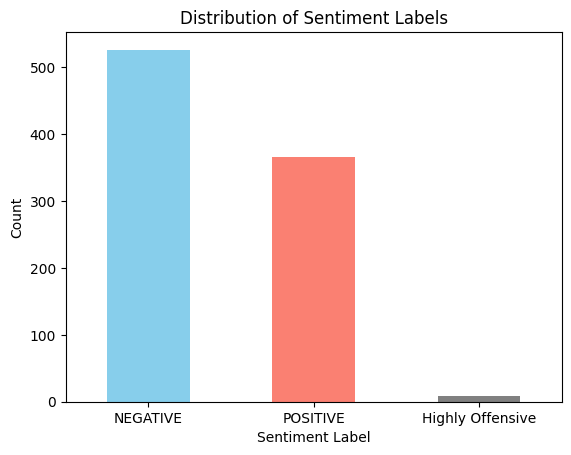


Sample Comments with Generated Gemma Responses:
                                                                                Comment Sentiment Label  Sentiment Score                                                                                                                                                                                                                  Gemma_Response
                                                      Logan Paul it's yo big day ‼️‼️‼️        POSITIVE         0.996544                                               The user said: 'Logan Paul it's yo big day ‼️‼️‼️'. Generate a friendly response.\n\nHere are some options:\n\nA.  "Hey Logan, congrats on your big day! Hope it's everything you
I've been following you from the start of your vine channel and have seen all 365 vlogs        POSITIVE         0.995116                                              The user said: 'I've been following you from the start of your vine channel and have seen all 3

In [22]:
# Cell N: Enhanced Interface for Sentiment and Text-Generation Results
import matplotlib.pyplot as plt

# Display a summary of sentiment labels
sentiment_counts = df_sentiments['Sentiment Label'].value_counts()
print(f"\n=== Sentiment Distribution ===\n{sentiment_counts}")

# Plot sentiment distribution
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'gray'])
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Display a sample of comments, their sentiment labels, and the generated Gemma responses
print("\nSample Comments with Generated Gemma Responses:")
print(df_sentiments[['Comment', 'Sentiment Label', 'Sentiment Score', 'Gemma_Response']].head(10).to_string(index=False))

In [23]:
# Cell O: Integrate Generated Responses into Final Classification Flow
# Create a new column to summarize all sentiment and response-related data
df_sentiments['Final_Output'] = (
    "Sentiment: " + df_sentiments['Sentiment Label'] +
    "\nSentiment Score: " + df_sentiments['Sentiment Score'].astype(str) +
    "\nGenerated Response: " + df_sentiments['Gemma_Response']
)

# Display a sample of the final output
print("\nSample of Final Output Summary for Comments:")
print(df_sentiments[['Comment', 'Final_Output']].head(10).to_string(index=False))


Sample of Final Output Summary for Comments:
                                                                                Comment                                                                                                                                                                                                                                                                                                  Final_Output
                                                      Logan Paul it's yo big day ‼️‼️‼️                                               Sentiment: POSITIVE\nSentiment Score: 0.9965435862541199\nGenerated Response: The user said: 'Logan Paul it's yo big day ‼️‼️‼️'. Generate a friendly response.\n\nHere are some options:\n\nA.  "Hey Logan, congrats on your big day! Hope it's everything you
I've been following you from the start of your vine channel and have seen all 365 vlogs                                              Sentiment: POSITIVE\nSentiment Score: 0.9

In [24]:
df_sentiments.to_csv("gemma_responses_intermediate.csv")